In [1]:
import os
import numpy as np
import librosa
import torch
import torchaudio
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
BASE_DIR = "/content/drive/MyDrive/DATASET(CSE425)"
AUDIO_DIR = os.path.join(BASE_DIR, "AUDIO")

PROC_DIR = os.path.join(BASE_DIR, "processed")
STATS_DIR = os.path.join(PROC_DIR, "audio_stats_chunks")
MEL_DIR = os.path.join(PROC_DIR, "mels_128x1024")

os.makedirs(PROC_DIR, exist_ok=True)
os.makedirs(STATS_DIR, exist_ok=True)
os.makedirs(MEL_DIR, exist_ok=True)

In [4]:
SR = 32000
N_MELS = 128
T_FRAMES = 1024
CHUNK_SIZE = 150

In [5]:
valid_ext = {".mp3", ".wav"}

audio_files = []
for fname in sorted(os.listdir(AUDIO_DIR)):
    ext = os.path.splitext(fname)[1].lower()
    if ext in valid_ext:
        audio_files.append(fname)

print("Total audio files found:", len(audio_files))
audio_files[:10]

Total audio files found: 3157


['Track0001.mp3',
 'Track0002.mp3',
 'Track0003.mp3',
 'Track0004.mp3',
 'Track0005.mp3',
 'Track0006.mp3',
 'Track0007.mp3',
 'Track0008.mp3',
 'Track0009.mp3',
 'Track0010.mp3']

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR,
    n_fft=2048,
    hop_length=512,
    n_mels=N_MELS,
    power=2.0
).to(device)

Using device: cpu


In [7]:
def extract_stats_and_mel(path, sr=SR):

    try:

        y, _ = librosa.load(path, sr=sr, mono=True)
        if y is None or len(y) < sr * 2:   # skip if < 2 seconds
            return None, None

        #ENERGY
        rms = librosa.feature.rms(y=y)
        energy = float(rms.mean())

        #HARMONIC/PERCUSSIVE+ACOUSTICNESS
        harm = librosa.effects.harmonic(y)
        perc = librosa.effects.percussive(y)
        harm_mean = float(np.mean(np.abs(harm)))
        perc_mean = float(np.mean(np.abs(perc)) + 1e-6)
        acousticness = harm_mean / perc_mean

        #ZERO CROSSING
        zcr = librosa.feature.zero_crossing_rate(y)
        zcr_mean = float(zcr.mean())


        centroid  = float(librosa.feature.spectral_centroid(y=y, sr=sr).mean())
        bandwidth = float(librosa.feature.spectral_bandwidth(y=y, sr=sr).mean())
        contrast  = float(librosa.feature.spectral_contrast(y=y, sr=sr).mean())
        rolloff   = float(librosa.feature.spectral_rolloff(y=y, sr=sr).mean())

        #TEMPO / RHYTHM / DANCEABILITY
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        tempo = float(tempo)  # scalar
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        onset_mean = float(onset_env.mean()) if onset_env.size > 0 else 0.0
        danceability = onset_mean / (tempo + 1e-6)

        #MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        mfcc_mean = mfcc.mean(axis=1)
        mfcc_std  = mfcc.std(axis=1)

        #CHROMA
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = chroma.mean(axis=1)

        # MEL SPECTROGRAM
        S = librosa.feature.melspectrogram(
            y=y, sr=sr, n_fft=2048, hop_length=512,
            n_mels=N_MELS, power=2.0
        )
        mel_db = librosa.power_to_db(S, ref=np.max)

        T = mel_db.shape[1]
        if T >= T_FRAMES:
            start = (T - T_FRAMES) // 2
            mel_fixed = mel_db[:, start:start+T_FRAMES]
        else:
            pad = T_FRAMES - T
            mel_fixed = np.pad(mel_db, ((0,0),(0,pad)), mode="constant")


        stats_vec = np.concatenate([
            [energy, danceability, acousticness],
            [zcr_mean],
            [centroid, bandwidth, contrast, rolloff],
            [tempo],
            mfcc_mean, mfcc_std,
            chroma_mean
        ], axis=0)


        stats_vec = stats_vec.astype(np.float32)
        if stats_vec.shape[0] != 61:
            print("WARN: unexpected stats length", stats_vec.shape[0], "for", path)
            return None, None

        stats_vec = np.nan_to_num(stats_vec, nan=0.0, posinf=0.0, neginf=0.0)
        mel_fixed = np.nan_to_num(mel_fixed, nan=0.0, posinf=0.0, neginf=0.0)

        return stats_vec, mel_fixed

    except Exception as e:
        print("ERROR processing", path, "->", e)
        return None, None


In [8]:
num_files  = len(audio_files)
num_chunks = (num_files + CHUNK_SIZE - 1) // CHUNK_SIZE
print("Total files:", num_files, "| Chunks:", num_chunks)

for chunk_idx in range(num_chunks):
    start = chunk_idx * CHUNK_SIZE
    end   = min((chunk_idx + 1) * CHUNK_SIZE, num_files)
    chunk_files = audio_files[start:end]

    stats_chunk_path = os.path.join(STATS_DIR, f"stats_chunk_{chunk_idx:03d}.npy")
    ids_chunk_path   = os.path.join(STATS_DIR, f"ids_chunk_{chunk_idx:03d}.npy")


    if os.path.exists(stats_chunk_path) and os.path.exists(ids_chunk_path):
        print(f"[Chunk {chunk_idx:03d}] Already exists, skipping.")
        continue

    print(f"[Chunk {chunk_idx:03d}] Processing files {start}–{end-1} ...")

    chunk_stats = []
    chunk_ids   = []

    for fname in tqdm(chunk_files):
        track_id = os.path.splitext(fname)[0]
        mel_path = os.path.join(MEL_DIR, f"{track_id}.npz")


        if os.path.exists(mel_path):

            chunk_ids.append(track_id)
            continue

        fpath = os.path.join(AUDIO_DIR, fname)
        stats_vec, mel_fixed = extract_stats_and_mel(fpath, sr=SR)

        if stats_vec is None or mel_fixed is None:
            continue

        np.savez_compressed(mel_path, mel=mel_fixed.astype(np.float32))
        chunk_stats.append(stats_vec)
        chunk_ids.append(track_id)

    if len(chunk_stats) > 0:
        chunk_stats = np.vstack(chunk_stats)
        chunk_ids   = np.array(chunk_ids)

        np.save(stats_chunk_path, chunk_stats)
        np.save(ids_chunk_path,   chunk_ids)

        print(f"[Chunk {chunk_idx:03d}] Saved stats for {len(chunk_ids)} tracks.")
    else:
        print(f"[Chunk {chunk_idx:03d}] No valid tracks in this chunk.")

Total files: 3157 | Chunks: 22
[Chunk 000] Already exists, skipping.
[Chunk 001] Already exists, skipping.
[Chunk 002] Already exists, skipping.
[Chunk 003] Already exists, skipping.
[Chunk 004] Already exists, skipping.
[Chunk 005] Already exists, skipping.
[Chunk 006] Already exists, skipping.
[Chunk 007] Already exists, skipping.
[Chunk 008] Already exists, skipping.
[Chunk 009] Already exists, skipping.
[Chunk 010] Already exists, skipping.
[Chunk 011] Already exists, skipping.
[Chunk 012] Already exists, skipping.
[Chunk 013] Already exists, skipping.
[Chunk 014] Already exists, skipping.
[Chunk 015] Already exists, skipping.
[Chunk 016] Already exists, skipping.
[Chunk 017] Already exists, skipping.
[Chunk 018] Already exists, skipping.
[Chunk 019] Already exists, skipping.
[Chunk 020] Processing files 3000–3149 ...


  0%|          | 0/150 [00:00<?, ?it/s]/tmp/ipython-input-2483168582.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tempo = float(tempo)  # scalar
100%|██████████| 150/150 [11:43<00:00,  4.69s/it]


[Chunk 020] Saved stats for 150 tracks.
[Chunk 021] Processing files 3150–3156 ...


100%|██████████| 7/7 [00:51<00:00,  7.29s/it]

[Chunk 021] Saved stats for 7 tracks.


In [9]:
stats_files = sorted([f for f in os.listdir(STATS_DIR) if f.endswith(".npy")])
mel_files   = sorted([f for f in os.listdir(MEL_DIR) if f.endswith(".npz")])

print("Stats chunks:", len(stats_files))
print("Mel files:", len(mel_files))


Stats chunks: 46
Mel files: 3249


In [10]:
import numpy as np

mel_ids = [f.replace(".npz","") for f in mel_files]
print("Unique mel ids:", len(set(mel_ids)))
print("Total mel ids:", len(mel_ids))
print("Duplicates:", len(mel_ids) - len(set(mel_ids)))


Unique mel ids: 3249
Total mel ids: 3249
Duplicates: 0


In [15]:
import numpy as np, os


stats_ids = []
for f in stats_files:
    arr = np.load(os.path.join(STATS_DIR, f))

    stats_ids.extend([str(x) for x in arr])

stats_ids = set(stats_ids)

mel_ids = set([os.path.splitext(f)[0] for f in mel_files])

print("Stats:", len(stats_ids))
print("Mel:", len(mel_ids))
print("Mel-only:", len(mel_ids - stats_ids))
print("Stats-only:", len(stats_ids - mel_ids))


Stats: 3049
Mel: 3249
Mel-only: 3249
Stats-only: 3049


In [16]:
arr = np.load(os.path.join(STATS_DIR, stats_files[0]))
print(type(arr))
print(arr.shape)
print(arr[:3])


<class 'numpy.ndarray'>
(150, 61)
[[ 8.51782486e-02  1.50740026e-02  2.51589847e+00  7.48813972e-02
   2.13427417e+03  2.43946411e+03  2.35375385e+01  4.39154785e+03
   7.21153870e+01 -1.92970749e+02  1.52166443e+02 -2.49549675e+01
   3.60896301e+01 -2.53429184e+01  2.40447006e+01 -2.61809673e+01
   1.37266417e+01 -1.44376869e+01  2.92193532e+00 -5.80401087e+00
  -1.78908992e+00  2.88600111e+00 -8.25391483e+00  1.55685258e+00
  -9.82712269e+00  7.84785795e+00 -9.51274967e+00  6.79836869e-01
  -8.98290730e+00  5.62587433e+01  2.75785027e+01  1.74358215e+01
   2.04086971e+01  1.93245029e+01  1.55254898e+01  1.52012024e+01
   1.23343754e+01  1.12850752e+01  1.11480675e+01  1.11632137e+01
   9.07687950e+00  1.03357763e+01  9.00671196e+00  8.70084858e+00
   8.06010914e+00  8.36112785e+00  8.09233761e+00  8.42790222e+00
   7.62607050e+00  3.42920631e-01  2.67834097e-01  3.35158616e-01
   2.27234602e-01  4.05599624e-01  4.27214175e-01  2.61203170e-01
   3.75352025e-01  3.00652295e-01  3.47960

In [17]:
stats_ids = []
for f in stats_files:
    chunk_idx = f.split("_")[2].replace(".npy","")
    ids_file = f"ids_chunk_{chunk_idx}.npy"
    ids_arr = np.load(os.path.join(STATS_DIR, ids_file))
    stats_ids.extend(ids_arr)

stats_ids = set(stats_ids)

mel_ids = set(os.path.splitext(f)[0] for f in mel_files)

print("Stats IDs:", len(stats_ids))
print("Mel IDs:", len(mel_ids))
print("Mel-only:", len(mel_ids - stats_ids))
print("Stats-only:", len(stats_ids - mel_ids))


Stats IDs: 3157
Mel IDs: 3249
Mel-only: 92
Stats-only: 0


# **VISUALIZATION**

In [18]:
import numpy as np
import os

all_stats = []

for f in sorted(os.listdir(STATS_DIR)):
    if f.endswith('.npy') and 'stats' in f:
        arr = np.load(os.path.join(STATS_DIR, f))
        all_stats.append(arr)

all_stats = np.vstack(all_stats)
print(all_stats.shape)


(3158, 61)


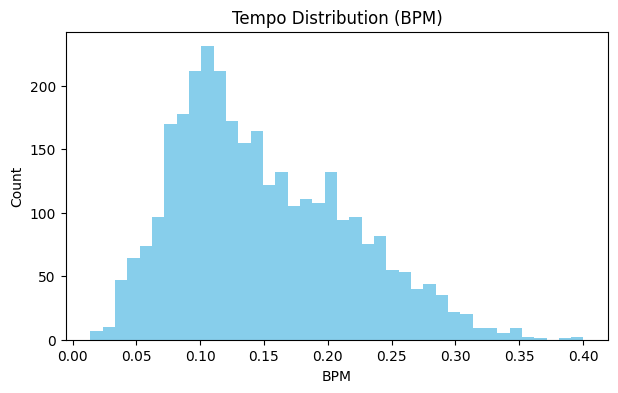

In [19]:
import matplotlib.pyplot as plt

tempo = all_stats[:, 0]
plt.figure(figsize=(7,4))
plt.hist(tempo, bins=40, color='skyblue')
plt.title("Tempo Distribution (BPM)")
plt.xlabel("BPM")
plt.ylabel("Count")
plt.show()


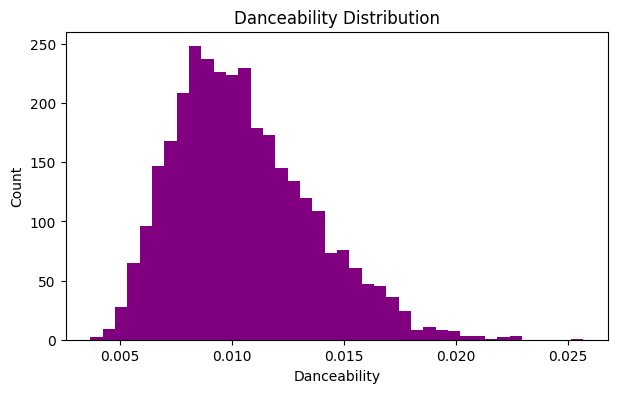

In [20]:
dance = all_stats[:, 1]
plt.figure(figsize=(7,4))
plt.hist(dance, bins=40, color='purple')
plt.title("Danceability Distribution")
plt.xlabel("Danceability")
plt.ylabel("Count")
plt.show()


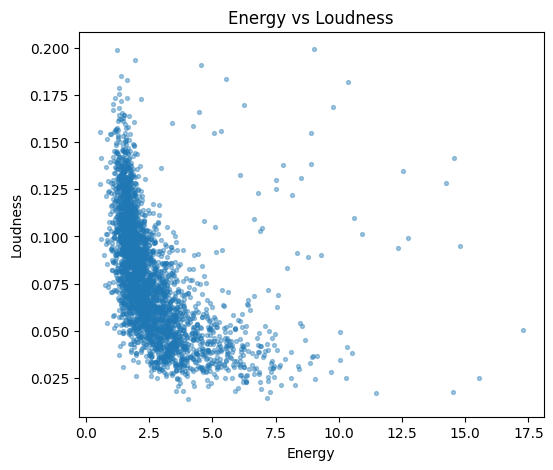

In [21]:
energy = all_stats[:, 2]
loudness = all_stats[:, 3]

plt.figure(figsize=(6,5))
plt.scatter(energy, loudness, alpha=0.4, s=8)
plt.title("Energy vs Loudness")
plt.xlabel("Energy")
plt.ylabel("Loudness")
plt.show()


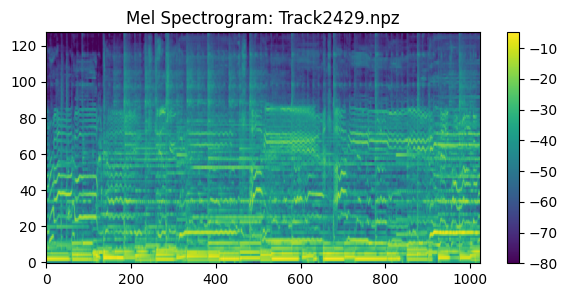

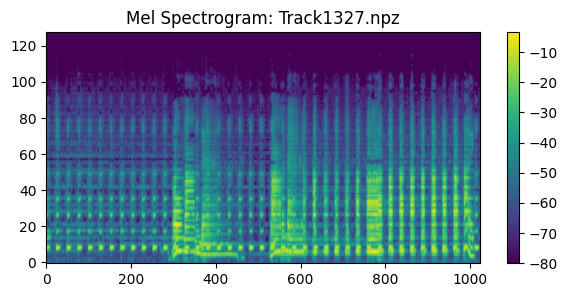

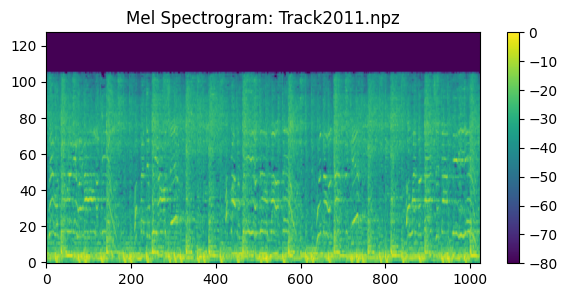

In [22]:
import random

samples = random.sample(os.listdir(MEL_DIR), 3)

for s in samples:
    mel = np.load(os.path.join(MEL_DIR, s))['mel']
    plt.figure(figsize=(7,3))
    plt.imshow(mel, aspect='auto', origin='lower')
    plt.title(f"Mel Spectrogram: {s}")
    plt.colorbar()
    plt.show()
